### Final Model - Uses NASNet

This model uses :
    1. NASNet as the base architecture 
    2. Batch size =64 and 150 epochs. 
    3. Uses processed (Histogram equalized) data 
    4. Without balanced weights.
    5. Uses LR scheduler step decay.

In [ ]:
import os
import numpy as np
import keras
import tensorflow as tf 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Convolution2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
#from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.nasnet import NASNetMobile
from keras.layers import Dense, Dropout, Flatten, Activation, GlobalAveragePooling2D
from keras.optimizers import RMSprop
import functools
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import RMSprop,Adam
from keras.callbacks import LearningRateScheduler
import math

In [2]:
IMG_ROWS, IMG_COLS = 224, 224
INPUT_SHAPE=(224, 224, 3)
PATH = 'data/processed_data/'
TRAIN_DATA_PATH = os.path.join(PATH, 'Training')
TEST_DATA_PATH = os.path.join(PATH, 'Testing')
BATCH_SIZE = 64
NUM_EPOCHS = 150
CLASS_MODE = 'categorical'
COLOR_MODE = 'rgb'
SAVE_FORMAT = 'png'
#40, 100 - 61
#64 batch size, 150 epoch ---62.43
#128, 150 -- 60.65

In [3]:

data_dir_list =np.sort(os.listdir(TRAIN_DATA_PATH))
data_dir_list

array(['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor'],
      dtype='<U16')

In [4]:

data_dir_list_Test =np.sort(os.listdir(TEST_DATA_PATH))
data_dir_list_Test

array(['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor'],
      dtype='<U16')

In [5]:
train_data_gen = ImageDataGenerator(
    rotation_range=50,
    brightness_range=[0.2,0.8],
    vertical_flip=True, 
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=[0.5,0.8],
    rescale=1./255,
    validation_split=0.2) 

In [6]:
train_generator = train_data_gen.flow_from_directory(
        TRAIN_DATA_PATH,
        target_size=(IMG_ROWS, IMG_COLS), 
        batch_size=BATCH_SIZE,
        class_mode=CLASS_MODE,
        color_mode=COLOR_MODE, 
        shuffle=True,   
        save_format=SAVE_FORMAT, 
        subset="training")


val_generator = train_data_gen.flow_from_directory(
    TRAIN_DATA_PATH,
    target_size=(IMG_ROWS, IMG_COLS), 
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    color_mode=COLOR_MODE, 
    shuffle=True,   
    save_format=SAVE_FORMAT, 
    subset='validation'
)

Found 2298 images belonging to 4 classes.
Found 573 images belonging to 4 classes.


In [7]:
train_generator.samples 

2298

In [8]:
train_generator.class_indices

{'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}

In [9]:
test_datagen = ImageDataGenerator(
    rescale=1./255
)

test_generator = test_datagen.flow_from_directory(
    TEST_DATA_PATH,
    target_size=(IMG_ROWS, IMG_COLS),
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    color_mode=COLOR_MODE, 
    shuffle = False,
    seed=None,  
    save_format=SAVE_FORMAT
)


Found 394 images belonging to 4 classes.


In [10]:

def create_nasnet_model():
    
    # Base model, with weights pre-trained on ImageNet.
    base_model = NASNetMobile(INPUT_SHAPE, weights='imagenet', include_top=False)

    for layer in base_model.layers:
        layer.trainable = False

    model = Sequential()
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.5))
    model.add(Dense(4, activation='softmax'))
    
    learning_rate = 0.1
    momentum = 0.8
    optimizer = keras.optimizers.SGD(lr=learning_rate, momentum=momentum, nesterov=False)

    model.compile(
        loss = 'categorical_crossentropy',
        optimizer = optimizer,
        metrics = ['accuracy']
    )
    
    return model

In [11]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=2)

In [12]:
def step_decay(epoch):
   initial_lrate = 0.1
   drop = 0.5
   epochs_drop = 10.0
   lrate = initial_lrate * math.pow(drop,  
           math.floor((1+epoch)/epochs_drop))
   return lrate

lr_scheduler =keras.callbacks.LearningRateScheduler(step_decay, verbose=1)

In [13]:

callbacks_list  = [lr_scheduler]

In [14]:
model = create_nasnet_model()

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=NUM_EPOCHS,
    workers=6,
    max_queue_size=100,
    verbose=True,
    callbacks=callbacks_list
)


Epoch 00001: LearningRateScheduler reducing learning rate to 0.1.
Epoch 1/150
36/36 [==============================] - 100s 3s/step - loss: 2.9486 - accuracy: 0.4843 - val_loss: 2.0810 - val_accuracy: 0.4660

Epoch 00002: LearningRateScheduler reducing learning rate to 0.1.
Epoch 2/150
36/36 [==============================] - 102s 3s/step - loss: 1.8131 - accuracy: 0.5949 - val_loss: 1.8822 - val_accuracy: 0.5899

Epoch 00003: LearningRateScheduler reducing learning rate to 0.1.
Epoch 3/150
36/36 [==============================] - 98s 3s/step - loss: 1.7149 - accuracy: 0.6014 - val_loss: 1.5025 - val_accuracy: 0.6387

Epoch 00004: LearningRateScheduler reducing learning rate to 0.1.
Epoch 4/150
36/36 [==============================] - 97s 3s/step - loss: 1.6980 - accuracy: 0.6140 - val_loss: 1.1020 - val_accuracy: 0.6422

Epoch 00005: LearningRateScheduler reducing learning rate to 0.1.
Epoch 5/150
36/36 [==============================] - 96s 3s/step - loss: 1.6575 - accuracy: 0.6101 


Epoch 00040: LearningRateScheduler reducing learning rate to 0.00625.
Epoch 40/150
36/36 [==============================] - 96s 3s/step - loss: 0.7311 - accuracy: 0.7237 - val_loss: 0.6737 - val_accuracy: 0.7033

Epoch 00041: LearningRateScheduler reducing learning rate to 0.00625.
Epoch 41/150
36/36 [==============================] - 96s 3s/step - loss: 0.7005 - accuracy: 0.7232 - val_loss: 0.6586 - val_accuracy: 0.7277

Epoch 00042: LearningRateScheduler reducing learning rate to 0.00625.
Epoch 42/150
36/36 [==============================] - 95s 3s/step - loss: 0.7074 - accuracy: 0.7315 - val_loss: 0.6909 - val_accuracy: 0.7120

Epoch 00043: LearningRateScheduler reducing learning rate to 0.00625.
Epoch 43/150
36/36 [==============================] - 95s 3s/step - loss: 0.7048 - accuracy: 0.7250 - val_loss: 0.6876 - val_accuracy: 0.7208

Epoch 00044: LearningRateScheduler reducing learning rate to 0.00625.
Epoch 44/150
36/36 [==============================] - 96s 3s/step - loss: 0.7

36/36 [==============================] - 96s 3s/step - loss: 0.6429 - accuracy: 0.7476 - val_loss: 0.7013 - val_accuracy: 0.7103

Epoch 00079: LearningRateScheduler reducing learning rate to 0.00078125.
Epoch 79/150
36/36 [==============================] - 100s 3s/step - loss: 0.6662 - accuracy: 0.7415 - val_loss: 0.6920 - val_accuracy: 0.6998

Epoch 00080: LearningRateScheduler reducing learning rate to 0.000390625.
Epoch 80/150
36/36 [==============================] - 97s 3s/step - loss: 0.6773 - accuracy: 0.7389 - val_loss: 0.7242 - val_accuracy: 0.6981

Epoch 00081: LearningRateScheduler reducing learning rate to 0.000390625.
Epoch 81/150
36/36 [==============================] - 96s 3s/step - loss: 0.6810 - accuracy: 0.7511 - val_loss: 0.6907 - val_accuracy: 0.7068

Epoch 00082: LearningRateScheduler reducing learning rate to 0.000390625.
Epoch 82/150
36/36 [==============================] - 103s 3s/step - loss: 0.6258 - accuracy: 0.7581 - val_loss: 0.6981 - val_accuracy: 0.7086

E


Epoch 00116: LearningRateScheduler reducing learning rate to 4.8828125e-05.
Epoch 116/150
36/36 [==============================] - 95s 3s/step - loss: 0.6697 - accuracy: 0.7402 - val_loss: 0.6843 - val_accuracy: 0.7051

Epoch 00117: LearningRateScheduler reducing learning rate to 4.8828125e-05.
Epoch 117/150
36/36 [==============================] - 95s 3s/step - loss: 0.6069 - accuracy: 0.7628 - val_loss: 0.6944 - val_accuracy: 0.7208

Epoch 00118: LearningRateScheduler reducing learning rate to 4.8828125e-05.
Epoch 118/150
36/36 [==============================] - 97s 3s/step - loss: 0.6763 - accuracy: 0.7450 - val_loss: 0.6945 - val_accuracy: 0.7051

Epoch 00119: LearningRateScheduler reducing learning rate to 4.8828125e-05.
Epoch 119/150
36/36 [==============================] - 104s 3s/step - loss: 0.6589 - accuracy: 0.7515 - val_loss: 0.6835 - val_accuracy: 0.6998

Epoch 00120: LearningRateScheduler reducing learning rate to 2.44140625e-05.
Epoch 120/150
36/36 [====================

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
NASNet (Functional)          (None, 7, 7, 1056)        4269716   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1056)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1056)              0         
_________________________________________________________________
dense (Dense)                (None, 4)                 4228      
Total params: 4,273,944
Trainable params: 4,228
Non-trainable params: 4,269,716
_________________________________________________________________


In [16]:
loss, accuracy = model.evaluate(test_generator)

print(f"Test Accuracy: {accuracy * 100}%")

7/7 [==============================] - 10s 1s/step - loss: 1.1192 - accuracy: 0.5838
Test Accuracy: 58.375632762908936%


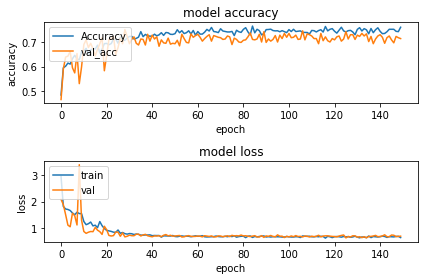

In [19]:

plt.figure(1)

# summarize history for accuracy
plt.subplot(211) 
plt.plot(history.history['accuracy']) 
plt.plot(history.history['val_accuracy']) 
plt.title('model accuracy') 
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Accuracy', 'val_acc'], loc='upper left')

# summarize history for loss
plt.subplot(212) 
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss']) 
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.tight_layout() 
plt.savefig('acc_loss.pdf')
plt.show()

In [21]:
import numpy as np

predictions = model.predict_generator(test_generator)
# Get most likely class
predicted_classes = np.argmax(predictions, axis=1)

In [22]:
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())   

In [24]:
from sklearn.metrics import classification_report

report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

                  precision    recall  f1-score   support

    glioma_tumor       0.49      0.40      0.44       100
meningioma_tumor       0.44      0.60      0.51       115
        no_tumor       0.73      0.66      0.69       105
 pituitary_tumor       0.84      0.70      0.76        74

        accuracy                           0.58       394
       macro avg       0.63      0.59      0.60       394
    weighted avg       0.61      0.58      0.59       394

